# Data treatment
This notebook is for the sole purpose of importing, cleaning, managing, and saving the data of the project. Both data from the excel sheet of the results, and from the images encoded by OpenPose.

In [1]:
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

#Imports and preparation for OpenPose

import sys
import cv2
import os
from sys import platform
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [15, 15]
%matplotlib inline


__file__ = os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/openpose/build/python/openpose/__init__.py')
sys.path.append(os.path.realpath('C:\\Users\\Marku\\Documents_no_sync\\Projet_Bachelor\\openpose\\build\\examples\\tutorial_api_python'))
dir_path = os.path.dirname(os.path.realpath(__file__))
if platform == "win32": sys.path.append(dir_path + '/../../python/openpose/');
else: sys.path.append('../../python');

try:
    from openpose import *
except:
    raise Exception('Error: OpenPose library could not be found. Did you enable `BUILD_PYTHON` in CMake and have this Python script in the right folder?')
params = dict()
params["logging_level"] = 3
params["output_resolution"] = "-1x-1"
params["net_resolution"] = "368x-1"
params["model_pose"] = "BODY_25"
params["alpha_pose"] = 0.6
params["scale_gap"] = 0.3
params["scale_number"] = 1
params["render_threshold"] = 0.05
# If GPU version is built, and multiple GPUs are available, set the ID here
params["num_gpu_start"] = 0
params["disable_blending"] = False
# Ensure you point to the correct path where models are located
params["default_model_folder"] = dir_path + "/../../../models/"
# Construct OpenPose object allocates GPU memory
openpose = OpenPose(params)

print("Imports and start of openpose success !")

Imports and start of openpose success !


In [2]:
plt.rcParams["figure.figsize"] = [15, 15]

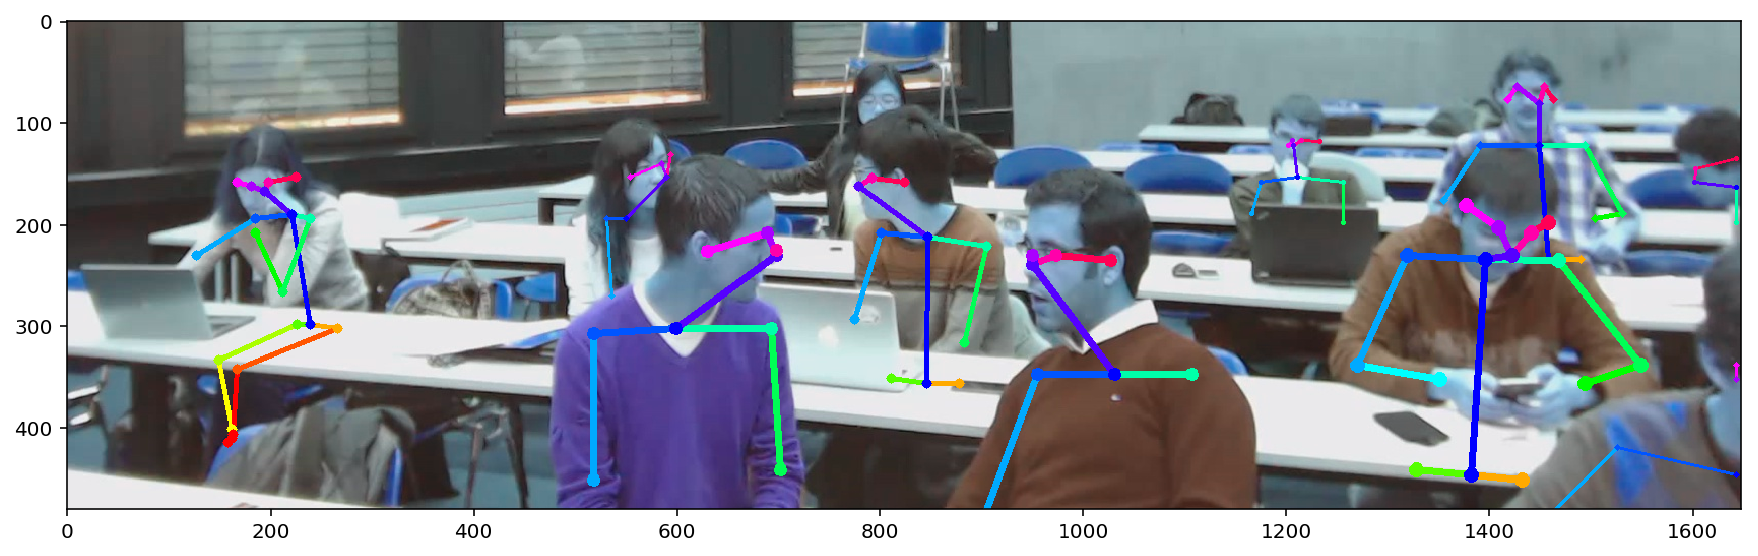

In [4]:
#image selection, processing, and display

# Read new image
# "../../../../../../Documents_no_sync/Projet_Bachelor/data/" == data of the project
img = cv2.imread("../../../../../../Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam4/pierre02_00001.jpg")

# Output keypoints and the image with the human skeleton blended on it
keypoints, output_image = openpose.forward(img, True)

plt.imshow(output_image)

## Excel file (Attention rating) import

In [3]:
file = 'C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/C2_alle.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Print the sheet names
print(xl.sheet_names)

# Load a sheet into a DataFrame by name: df1
df1 = xl.parse('C2_alle')

print('Successfully imported the excel file')

['C2_alle']
Successfully imported the excel file


## Import data from images in directory
Store them in numpy array, and save that array to an extern file to avoid time re-process that every time.

In [ ]:
directory= os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam4')

keypoints_all = np.zeros(keypoints[0].shape)

for file in os.listdir(directory):
    filename = os.path.join(directory, file)
    if filename.endswith("jpg"): 
        img = cv2.imread(filename)
        
        print(filename)

        # Output keypoints and the image with the human skeleton blended on it
        keypoints, output_image = openpose.forward(img, True)
        
        for i in range(keypoints.shape[0]):
            keypoints_all = np.concatenate((keypoints_all, keypoints[i]), axis=1)
            
keypoints_all = keypoints_all[:, 3:] #removes the first 3 columns that were created at the beginning

In [ ]:
keypoints_file = 'keypoints_file_pierre_cam4'

In [ ]:
np.save(keypoints_file, keypoints_all)

Data is now imported from the excel file, and stored in a `panda dataframe`, and extracted from the images, stored in the file `keypoints_file`. What is now still to do is get rid of columns that are useless, and separate by id number. 

## Processing of the excel data

We will only keep the data from participants 93 and 105, because it is the one that are hardcoded to be of use in cam4 of the course of Pierre Dillembourg (in the pptx given by Zurich). Afterwards, we need to drop all the columns that have no interest, or only keep the ones that may represent some useful data. 

In [ ]:
df_participants = df1[(df1['Participant'] == 93) | (df1['Participant'] == 105)]

In [4]:
df_participants = df1[(df1['Participant'] == 93) | (df1['Participant'] == 105)]

df_selected = df_participants[['Global Attention Rating']]
df_selected

,Global Attention Rating
2034,6
2035,4
2036,7
2037,7
2038,7
2039,7
2040,6
2041,7
2042,7
2043,7


The excel data is now trimmed down to what interests us, ie only participants number 93 and 105, and only the columns giving the scores.

## Processing of the images data

In [ ]:
imported_keypoints = np.load(keypoints_file + '.npy')

In [ ]:
imported_keypoints.shape

The data is ordered, each 3 columns form a keypoints set for one person in one picture. Maybe it would be better to flatten that ?

In [ ]:
flattened_keypoints = np.zeros((keypoints[0].flatten().shape[0], 1))
for i in range(0, imported_keypoints.shape[1], 3):
    temp = imported_keypoints[:, i:i+3]
    flattened_keypoints = np.concatenate((flattened_keypoints, temp.flatten()[:, np.newaxis]), axis=1)
    

flattened_keypoints = flattened_keypoints[:, 1:] #removes the first column that was created at the beginning
print(flattened_keypoints.shape, ' has the correct shape ?')
print(flattened_keypoints.shape[0] == imported_keypoints.shape[0] * 3 and flattened_keypoints.shape[1] == imported_keypoints.shape[1] / 3)

Now every column contains the data of a single person in a single frame.

### Problem with too much data on a single frame

However, a problem that could arise is that the NN takes into account people that are not graded on the current camera view. This can be solved either by selescting the columns that match the people concerned by this camera, or simply by cropping the image before giving it to openpose. This makes for an easy way to throw out people we are not interested in in that camera. This is possible because the cameras do not move, and neither do the students. 

In [ ]:
# "../../../../../../Documents_no_sync/Projet_Bachelor/data/" == data of the project
img = cv2.imread("../../../../../../Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam4/pierre_0200001.jpg")

img_cropped = img[:, 450:750]

print(img.shape, img_cropped.shape)

#plt.imshow(cv2.cvtColor(img_cropped, cv2.COLOR_BGR2RGB))

# Output keypoints and the image with the human skeleton blended on it
keypoints, output_image = openpose.forward(img_cropped, True)

print(keypoints)

#img_cropped = img[:, 450:750]
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

### Problème
Impossible de crop les images, je ne sais pas pourquoi. Il semblerait qu'OpenPose connaisse les dimensions initales des images, et traite ensuite toutes les entrées comme des images ayant toutes ces mêmes dimensions. Cela provoque une grande distortion des images croppées après qu'elle soient passées dans OpenPose. Il va falloir isoler les composants à la main dans la valeur de sortie `keypoints` de `openpose.forward`.  
Ou faire un masque afin de conserver les dimensions des images !

[[[6.9797748e+02 2.3010214e+02 9.6587801e-01]
  [5.9905426e+02 3.0220978e+02 9.1300327e-01]
  [5.1814313e+02 3.0671982e+02 9.1443664e-01]
  [5.1780286e+02 4.5056830e+02 6.9583368e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [6.9342523e+02 3.0204694e+02 9.1884989e-01]
  [6.9819659e+02 4.4142178e+02 8.1605738e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [6.8890601e+02 2.1202493e+02 8.4534568e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [6.3040814e+02 2.2552477e+02 9.6088874e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0

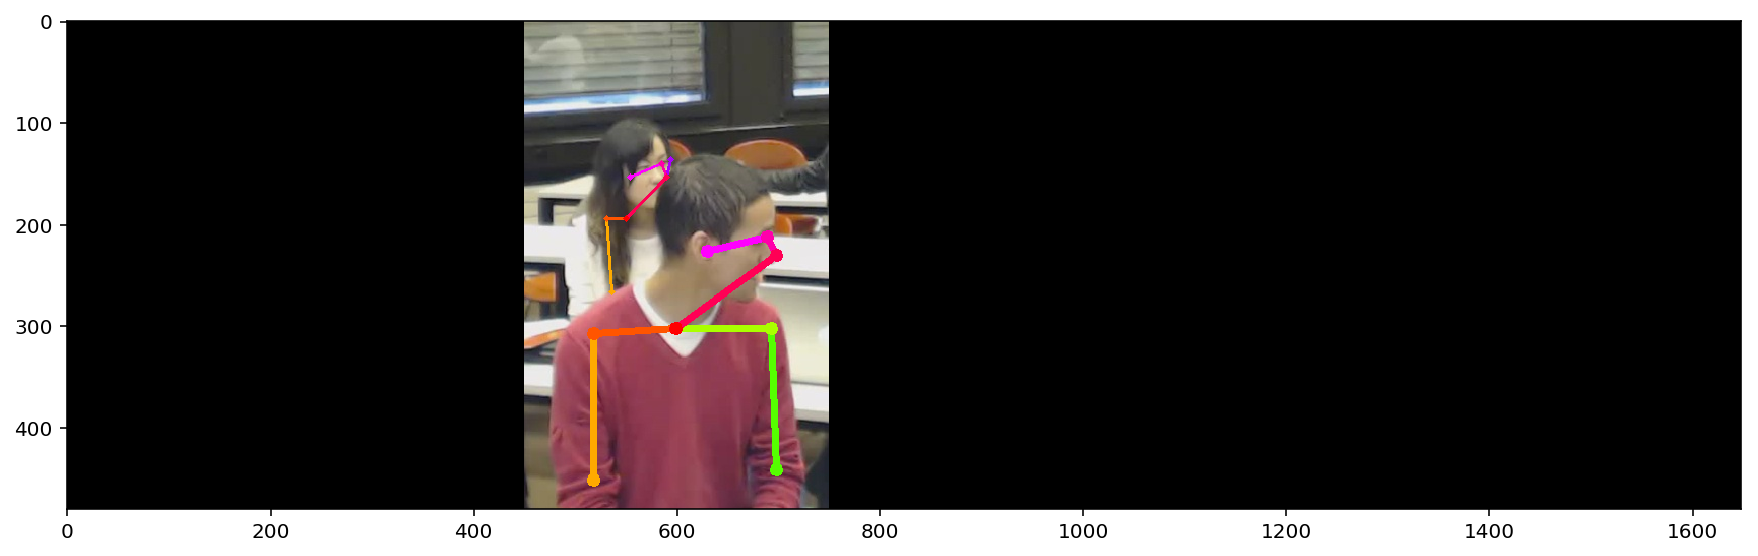

In [3]:
# "../../../../../../Documents_no_sync/Projet_Bachelor/data/" == data of the project
img = cv2.imread("../../../../../../Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam4/pierre_0200001.jpg")

img_masked = np.copy(img)
left_bound = 450
right_bound = 750
img_masked[:, :left_bound] = 0
img_masked[:, right_bound:] = 0

# Output keypoints and the image with the human skeleton blended on it
keypoints, output_image = openpose.forward(img_masked, True)

print(keypoints)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

In [7]:
directory= os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam4')

keypoints_masked = np.zeros(keypoints[0].shape)
left_bound = 450
right_bound = 750

for file in os.listdir(directory):
    filename = os.path.join(directory, file)
    if filename.endswith("jpg"): 
        img = cv2.imread(filename)
        img_masked = np.copy(img)
        img_masked[:, :left_bound] = 0
        img_masked[:, right_bound:] = 0
        
        keypoints = openpose.forward(img_masked)
        
        for i in range(keypoints.shape[0]):
            keypoints_masked = np.concatenate((keypoints_masked, keypoints[i]), axis=1)
            
keypoints_masked = keypoints_masked[:, 3:] #removes the first 3 columns that were created at the beginning

keypoints_masked_file = 'keypoints_file_pierre_cam4_masked'
np.save(keypoints_masked_file, keypoints_masked)

print("Successfull")

Successfull


### Points with frame number
On a maintenant besoin du numéro de la frame de laquelle les keypoints ont été extraits. Il suffit pour cela de rajouter une ligne dans la matrice ```keypoints_masked```.

In [31]:
directory= os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam4')

keypoints_flat_frame_number = np.zeros((keypoints[0].flatten().shape[0] + 1, 1))
left_bound = 450
right_bound = 750

frame_number = 0

for file in os.listdir(directory):
    filename = os.path.join(directory, file)
    if filename.endswith("jpg"): 
        img = cv2.imread(filename)
        img_masked = np.copy(img)
        img_masked[:, :left_bound] = 0
        img_masked[:, right_bound:] = 0
        
        keypoints = openpose.forward(img_masked)
        
        for i in range(keypoints.shape[0]):
            temp = keypoints[i].flatten()
            temp = np.concatenate((np.array([frame_number]), temp), axis=0)
            keypoints_flat_frame_number = np.concatenate((keypoints_flat_frame_number, temp[:, np.newaxis]), axis=1)
            
    frame_number += 1
            
keypoints_flat_frame_number = keypoints_flat_frame_number[:, 1:] #removes the first column that was created at the beginning

keypoints_flat_frame_number_file = 'keypoints_file_pierre_cam4_flat_frame_number'
np.save(keypoints_flat_frame_number_file, keypoints_flat_frame_number)

print("Successfull")

Successfull


This stores the keypoints of only non-masked people still appearing in the frame. It flattens the keypoints such that a column corresponds to a set of keypoints for a person. It also pre-appends the frame number this set was found in. 

------
## More data
Now that the problem with associating keypoints to their respective id is solved, we can work with all the people in it again.

In [4]:
directory= os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam1')

keypoints_cam1 = np.zeros((keypoints[0].flatten().shape[0] + 1, 1))

frame_number = 0

for file in os.listdir(directory):
    filename = os.path.join(directory, file)
    if filename.endswith("jpg"): 
        img = cv2.imread(filename)
        
        keypoints = openpose.forward(img)
        
        for i in range(keypoints.shape[0]):
            temp = keypoints[i].flatten()
            temp = np.concatenate((np.array([frame_number]), temp), axis=0)
            keypoints_cam1 = np.concatenate((keypoints_cam1, temp[:, np.newaxis]), axis=1)
            
    frame_number += 1
            
keypoints_cam1 = keypoints_cam1[:, 1:] #removes the first column that was created at the beginning

keypoints_cam1_file = 'keypoints_pierre03_cam1'
np.save(keypoints_cam1_file, keypoints_cam1)

print("Successfull")

Successfull


-----
## More more data
Take into account all the cameras for class 02

In [3]:
os.listdir('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted')

['cam1', 'cam2', 'cam3', 'cam4', 'cam5', 'cam6']

In [5]:
##1

directory= os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam1')

keypoints_cam1 = np.zeros((keypoints[0].flatten().shape[0] + 2, 1))

frame_number = 0
cam_number = 1

for file in os.listdir(directory):
    filename = os.path.join(directory, file)
    if filename.endswith("jpg"): 
        img = cv2.imread(filename)
        
        keypoints = openpose.forward(img)
        
        for i in range(keypoints.shape[0]):
            temp = keypoints[i].flatten()
            temp_2 = np.array([cam_number, frame_number])
            temp = np.hstack((temp_2, temp))
            keypoints_cam1 = np.concatenate((keypoints_cam1, temp[:, np.newaxis]), axis=1)
            
    frame_number += 1
            
keypoints_cam1 = keypoints_cam1[:, 1:] #removes the first column that was created at the beginning

print("Successfull")

##2

directory= os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam2')

keypoints_cam2 = np.zeros((keypoints[0].flatten().shape[0] + 2, 1))

frame_number = 0
cam_number = 2

for file in os.listdir(directory):
    filename = os.path.join(directory, file)
    if filename.endswith("jpg"): 
        img = cv2.imread(filename)
        
        keypoints = openpose.forward(img)
        
        for i in range(keypoints.shape[0]):
            temp = keypoints[i].flatten()
            temp_2 = np.array([cam_number, frame_number])
            temp = np.hstack((temp_2, temp))
            keypoints_cam2 = np.concatenate((keypoints_cam2, temp[:, np.newaxis]), axis=1)
            
    frame_number += 1
            
keypoints_cam2 = keypoints_cam2[:, 1:] #removes the first column that was created at the beginning

print("Successfull")

##3

directory= os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam3')

keypoints_cam3 = np.zeros((keypoints[0].flatten().shape[0] + 2, 1))

frame_number = 0
cam_number = 3

for file in os.listdir(directory):
    filename = os.path.join(directory, file)
    if filename.endswith("jpg"): 
        img = cv2.imread(filename)
        
        keypoints = openpose.forward(img)
        
        for i in range(keypoints.shape[0]):
            temp = keypoints[i].flatten()
            temp_2 = np.array([cam_number, frame_number])
            temp = np.hstack((temp_2, temp))
            keypoints_cam3 = np.concatenate((keypoints_cam3, temp[:, np.newaxis]), axis=1)
            
    frame_number += 1
            
keypoints_cam3 = keypoints_cam3[:, 1:] #removes the first column that was created at the beginning


print("Successfull")

##4

directory= os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam4')

keypoints_cam4 = np.zeros((keypoints[0].flatten().shape[0] + 2, 1))

frame_number = 0
cam_number = 4

for file in os.listdir(directory):
    filename = os.path.join(directory, file)
    if filename.endswith("jpg"): 
        img = cv2.imread(filename)
        
        keypoints = openpose.forward(img)
        
        for i in range(keypoints.shape[0]):
            temp = keypoints[i].flatten()
            temp_2 = np.array([cam_number, frame_number])
            temp = np.hstack((temp_2, temp))
            keypoints_cam4 = np.concatenate((keypoints_cam4, temp[:, np.newaxis]), axis=1)
            
    frame_number += 1
            
keypoints_cam4 = keypoints_cam4[:, 1:] #removes the first column that was created at the beginning

print("Successfull")

keypoints_lesson03 = np.concatenate([keypoints_cam1, keypoints_cam2, keypoints_cam3, keypoints_cam4], axis=1)

keypoints_lesson03_file = 'keypoints_pierre03'
np.save(keypoints_lesson03_file, keypoints_lesson03)

print("Successfull")

Successfull
Successfull
Successfull
Successfull
Successfull


# Data for linear interpolation
Same as before, but with more images, and chang ein the name of the file

In [5]:
##1

directory= os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam1')

keypoints_cam1 = np.zeros((keypoints[0].flatten().shape[0] + 2, 1))

frame_number = 0
cam_number = 1

for file in os.listdir(directory):
    filename = os.path.join(directory, file)
    if filename.endswith("jpg"): 
        img = cv2.imread(filename)
        
        keypoints = openpose.forward(img)
        
        for i in range(keypoints.shape[0]):
            temp = keypoints[i].flatten()
            temp_2 = np.array([cam_number, frame_number])
            temp = np.hstack((temp_2, temp))
            keypoints_cam1 = np.concatenate((keypoints_cam1, temp[:, np.newaxis]), axis=1)
            
    frame_number += 1
            
keypoints_cam1 = keypoints_cam1[:, 1:] #removes the first column that was created at the beginning

print("Successfull")

##2

directory= os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam2')

keypoints_cam2 = np.zeros((keypoints[0].flatten().shape[0] + 2, 1))

frame_number = 0
cam_number = 2

for file in os.listdir(directory):
    filename = os.path.join(directory, file)
    if filename.endswith("jpg"): 
        img = cv2.imread(filename)
        
        keypoints = openpose.forward(img)
        
        for i in range(keypoints.shape[0]):
            temp = keypoints[i].flatten()
            temp_2 = np.array([cam_number, frame_number])
            temp = np.hstack((temp_2, temp))
            keypoints_cam2 = np.concatenate((keypoints_cam2, temp[:, np.newaxis]), axis=1)
            
    frame_number += 1
            
keypoints_cam2 = keypoints_cam2[:, 1:] #removes the first column that was created at the beginning

print("Successfull")

##3

directory= os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam3')

keypoints_cam3 = np.zeros((keypoints[0].flatten().shape[0] + 2, 1))

frame_number = 0
cam_number = 3

for file in os.listdir(directory):
    filename = os.path.join(directory, file)
    if filename.endswith("jpg"): 
        img = cv2.imread(filename)
        
        keypoints = openpose.forward(img)
        
        for i in range(keypoints.shape[0]):
            temp = keypoints[i].flatten()
            temp_2 = np.array([cam_number, frame_number])
            temp = np.hstack((temp_2, temp))
            keypoints_cam3 = np.concatenate((keypoints_cam3, temp[:, np.newaxis]), axis=1)
            
    frame_number += 1
            
keypoints_cam3 = keypoints_cam3[:, 1:] #removes the first column that was created at the beginning


print("Successfull")

##4

directory= os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam4')

keypoints_cam4 = np.zeros((keypoints[0].flatten().shape[0] + 2, 1))

frame_number = 0
cam_number = 4

for file in os.listdir(directory):
    filename = os.path.join(directory, file)
    if filename.endswith("jpg"): 
        img = cv2.imread(filename)
        
        keypoints = openpose.forward(img)
        
        for i in range(keypoints.shape[0]):
            temp = keypoints[i].flatten()
            temp_2 = np.array([cam_number, frame_number])
            temp = np.hstack((temp_2, temp))
            keypoints_cam4 = np.concatenate((keypoints_cam4, temp[:, np.newaxis]), axis=1)
            
    frame_number += 1
            
keypoints_cam4 = keypoints_cam4[:, 1:] #removes the first column that was created at the beginning

print("Successfull")

keypoints_lesson03 = np.concatenate([keypoints_cam1, keypoints_cam2, keypoints_cam3, keypoints_cam4], axis=1)

keypoints_lesson03_file = 'keypoints_pierre03_augmented'
np.save(keypoints_lesson03_file, keypoints_lesson03)

print("Successfull")

Successfull
Successfull
Successfull
Successfull
Successfull
